In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Задача 1

По аналогии с предыдущими лабораторными определим функцию для создания сеток узлов

In [2]:
def generate_grid(right_border, num_splits):
    step = right_border / num_splits
    grid = np.linspace(0, right_border, num_splits+1)
    return step, grid

Функция для метода прогонки

In [3]:
def tridiagonal_algorithm(a,b,c,f):
    a, b, c, f = tuple(map(lambda k_list: list(map(float, k_list)), (a, b, c, f)))

    alpha = [-b[0] / c[0]]
    beta = [f[0] / c[0]]
    n = len(f)
    x = [0]*n

    for i in range(1, n):
        alpha.append(-b[i]/(a[i]*alpha[i-1] + c[i]))
        beta.append((f[i] - a[i]*beta[i-1])/(a[i]*alpha[i-1] + c[i]))

    x[n-1] = beta[n - 1]

    for i in range(n - 1, 0, -1):
        x[i - 1] = alpha[i - 1]*x[i] + beta[i - 1]

    return x

Функция, определяющая точное решение

In [4]:
def u(x,t):
    return np.sin(x+t)

Функции, определяющие входные данные нашей дифференциальной задачи

In [74]:
def u_0(x):
    return np.sin(x)

def f(x,t):
    return np.sqrt(2) * np.sin(np.pi/4 + x + t)

def mu_0(t):
    return - np.cos(t) + 2 * np.sin(t)

def mu_1(t):
    return np.sin(t + 1)

Функция, определяющая реализацию разностной схемы

In [94]:
def diff_scheme_solve(x, t, h, tau, sigma, u_0, phi, mu_01, mu_1):

    y = np.zeros((len(x), len(t)))

    for k in range(len(x)):
        y[k, 0] = u_0(x[k])

    for j in range(len(t)-1):
        gamma = [-(2*sigma+sigma/h+1/tau * (h/2 * (1+2*h/3)))]
        beta = [sigma/h]
        g = [-(1-sigma)/h*y[1,j]+((1-sigma)*(1/h + 2)-h/(2*tau)*(1+2*h/3))*y[0,j] - mu_01(t[j+1])] 
        alpha = [0]
        for k in range(1, len(x)-1):
            alpha.append(sigma/h**2)
            gamma.append(-(2*sigma / h**2+1/tau))
            beta.append(sigma/h**2)
            g.append(-(1/tau*y[k,j] + (1-sigma)*(y[k-1, j] - 2*y[k,j] + y[k+1,j])/h**2 + phi(x[k], t[j])))
        alpha.append(0)
        gamma.append(1)
        g.append(mu_1(t[j+1]))
        beta.append(0)
        y[:, j+1] = tridiagonal_algorithm(alpha,beta,gamma,g)

    return y

Создание сетки узлов:

In [161]:
h, x_grid = generate_grid(1, 100)
tau, t_grid = generate_grid(10, 100)

In [162]:
print('tau=' + str(tau) + '\nh=' + str(h)) 

tau=0.1
h=0.01


Проверка неравенства Куранта

In [163]:
tau < h**2 / 2

False

Определяем вариационные параметры, влияющие на порядок аппроксимации

In [164]:
def dfdt(x,t):
    return np.cos(np.pi / 4 + x + t)

def dfdx(x,t):
    return np.cos(np.pi / 4 + x + t)

def d2fdx2(x,t):
    return -f(x,t)

def dmu0dt(t):
    return np.sin(t) + 2*np.cos(t)

In [174]:
sigma = 1/2 - h**2 / (12*tau)
def phi(x,t):
    return f(x,t) + tau/2 * dfdt(x,t) + h**2/12 * d2fdx2(x,t)
def mu_01(t):
    return mu_0(t) + h/2 * f(0,t) + (tau/2 + h**2/12) * dmu0dt(t) + h**2 /2 * dfdx(0,t) + h**3 / 24 * d2fdx2(0,t) + tau * h / 4 * dfdt(0,t)

Находим приближенное решение

In [171]:
y = diff_scheme_solve(x_grid, t_grid, h, tau, sigma, u_0, phi, mu_01, mu_1)

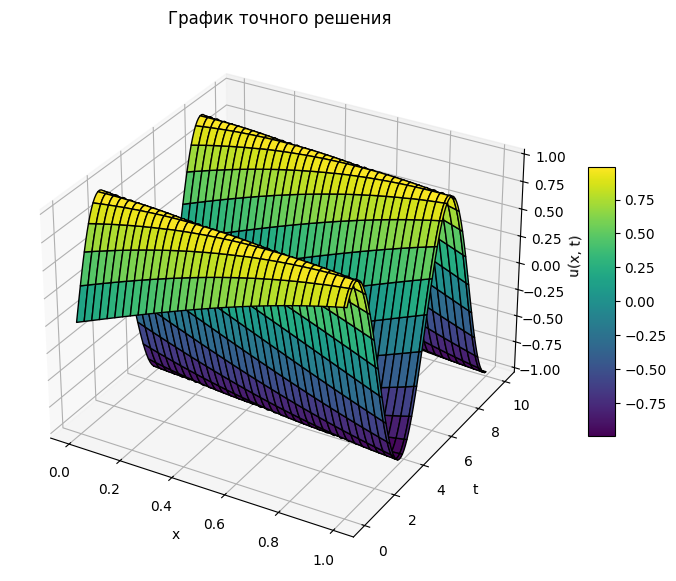

In [175]:
def print_exact():
    X, T = np.meshgrid(x_grid, t_grid)
    U = np.zeros_like(X)
    for i in range(T.shape[0]):
        U[i, :] = u(X[i, :], T[i, 0])
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T, U, cmap='viridis', edgecolor='k')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    plt.title('График точного решения')
    plt.show()

print_exact()

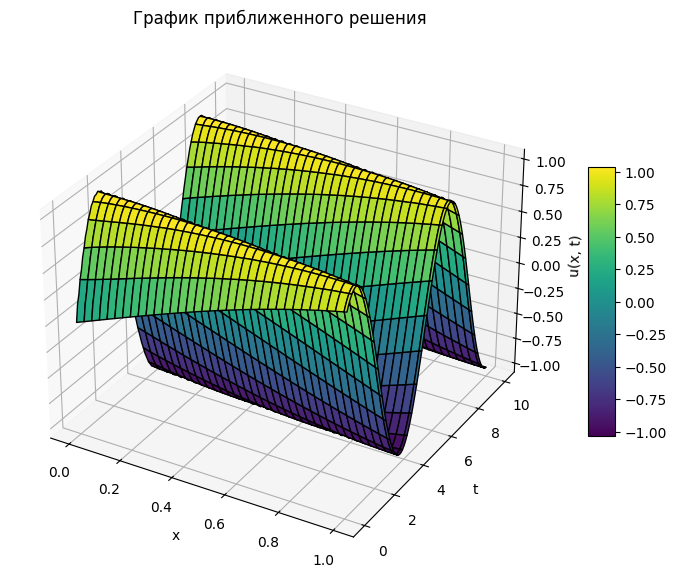

In [176]:
def print_approx():
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    X, T = np.meshgrid(x_grid, t_grid)
    
    Y = y.T
    
    surf = ax.plot_surface(X, T, Y, cmap='viridis', edgecolor='k')
    
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    plt.title('График приближенного решения')
    plt.show()

print_approx()

# Задача 2

In [177]:
def u_0(x):
    return np.sin(x)

def f(x,t):
    return (x+t+1)*np.sin(x+t)

def mu_0(t):
    return np.sin(t)

def mu_1(t):
    return -np.sqrt(2)*np.sin(t + 1 + np.pi/4)

def k(x,t):
    return x + t + 1

In [178]:
def diff_scheme_solve(x, t, h, tau, sigma, f, u_0, mu_0, mu_1, k):

    y = np.zeros((len(x), len(t)))

    for i in range(len(x)):
        y[i, 0] = u_0(x[i])

    for j in range(len(t)-1):
        gamma = [1]
        beta = [0]
        g = [mu_0(t[j+1])] 
        alpha = [0]
        for i in range(1, len(x)-1):
            alpha.append(sigma/h**2 * k(x[i] - h/2, t[j] + tau/2))
            gamma.append(-(sigma / h**2*(k(x[i] - h/2, t[j] + tau/2) + k(x[i] + h/2, t[j] + tau/2))+1/tau))
            beta.append(sigma/h**2*k(x[i] + h/2, t[j] + tau/2))
            g.append(-(1/tau*y[i,j] + (1-sigma)*(k(x[i] - h/2, t[j] + tau/2)*y[i-1, j] - k(x[i] - h/2, t[j] + tau/2)*y[i,j] - k(x[i] + h/2, t[j] + tau/2)*y[i,j] + k(x[i] + h/2, t[j] + tau/2)*y[i+1,j])/h**2 + f(x[i], t[j]+tau/2)))
        alpha.append(sigma/h)
        gamma.append(-sigma*(1/h+1))
        g.append((1-sigma)*(1/h+1)*y[len(x)-1, j] - (1-sigma)/h*y[len(x)-2,j] + mu_1(t[j+1]))
        beta.append(0)
        y[:, j+1] = tridiagonal_algorithm(alpha,beta,gamma,g)

    return y

In [180]:
h, x_grid = generate_grid(1, 100)
tau, t_grid = generate_grid(10, 100)

In [181]:
print('tau=' + str(tau) + '\nh=' + str(h)) 

tau=0.1
h=0.01


In [187]:
sigma = 1/2

Находим приближенное решение

In [188]:
y = diff_scheme_solve(x_grid, t_grid, h, tau, sigma, f, u_0, mu_0, mu_1, k)

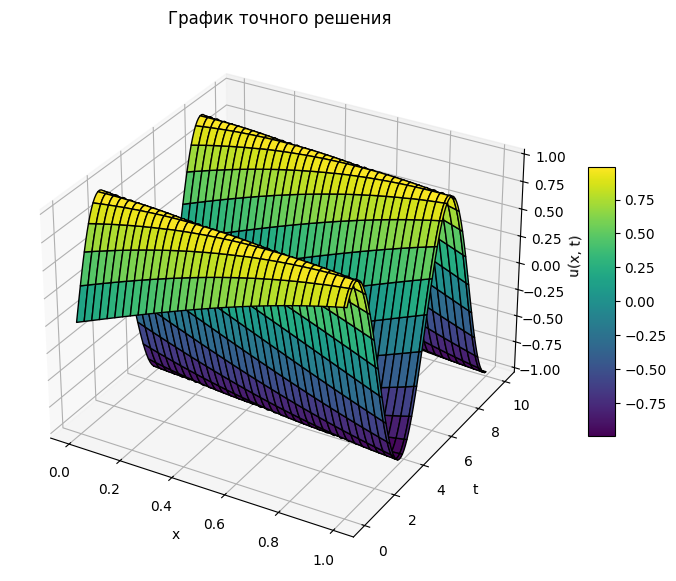

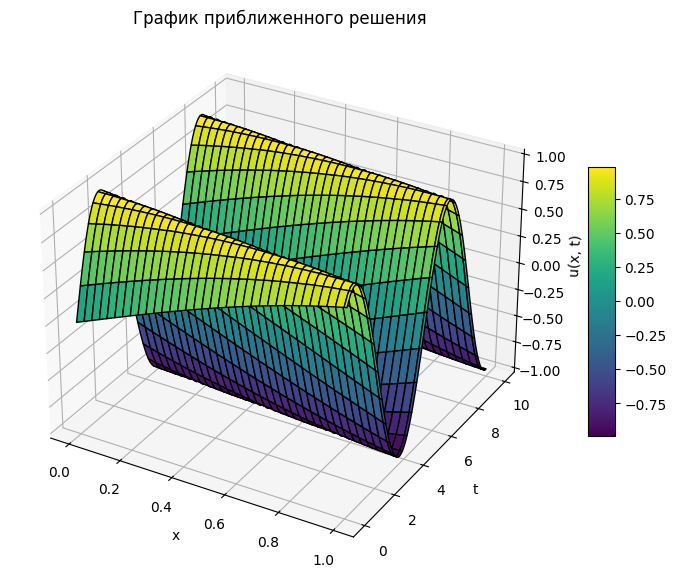

In [189]:
print_exact()
print_approx()